In this Notebook I will show how to solve Fashion MNIST dataset with Multilayer Perceptron.

### Import

In [0]:
!pip install -q keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.datasets import fashion_mnist
from keras.callbacks import EarlyStopping

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import os
import random as rn
import numpy as np

# Randomness control
os.environ['PYTHONHASHSEED'] = '0'
RANDOM_SEED = 3939
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, 
                              inter_op_parallelism_threads=1)

tf.set_random_seed(RANDOM_SEED)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
keras.backend.set_session(sess)

### Constants

In [0]:
CLASS_NUMBER = 10

IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28

TRAIN_IMAGE_NUMBER = 60000
TEST_IMAGE_NUMBER = 10000

### Loading Data

Fashion MNIST data is being built into ``from keras.datasets`` module.

In [0]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

### Data Visualisation

In [0]:
def show_images(X_train, y_train, rows_num=6):    
    figure, axes = plt.subplots(nrows=rows_num, ncols=6, sharex=True, sharey=True, figsize=(20, rows_num * 2))
    
    for row_index in range(rows_num):
        ax_row = axes[row_index]
        images = X_train[(row_index*8):(row_index+1)*8]
        labels = y_train[(row_index*8):(row_index+1)*8]
        
        for ax, img, label in zip(ax_row, images, labels):
            ax.imshow(img, cmap='gray_r')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title("Label - {}".format(label))

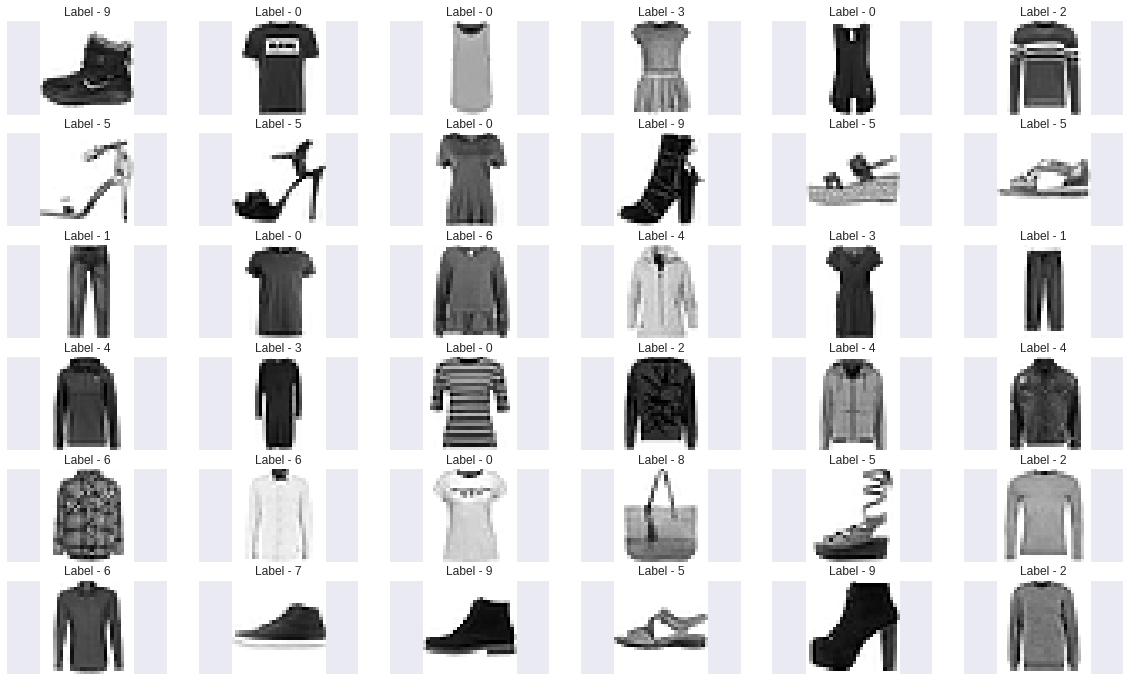

In [37]:
show_images(X_train, y_train)

### Data Preprocessing

Unwrapping image matrices into vectors

In [38]:
print("Training data - before unwrapping: ")
print(" - shape: {}".format(X_train.shape))
print(" - label: {}".format(y_train.shape))
print("Test data - before unwrapping: ")
print(" - shape: {}".format(X_test.shape))
print(" - label: {}".format(y_test.shape))

X_train = X_train.reshape(TRAIN_IMAGE_NUMBER, IMAGE_WIDTH * IMAGE_HEIGHT)
X_test = X_test.reshape(TEST_IMAGE_NUMBER, IMAGE_WIDTH * IMAGE_HEIGHT)

print("\nTraining data - after unwrapping: ")
print(" - shape: {}".format(X_train.shape))
print(" - label: {}".format(y_train.shape))
print("Test data - after unwrapping: ")
print(" - shape: {}".format(X_test.shape))
print(" - label: {}".format(y_test.shape))

Training data - before unwrapping: 
 - shape: (60000, 28, 28)
 - label: (60000,)
Test data - before unwrapping: 
 - shape: (10000, 28, 28)
 - label: (10000,)

Training data - after unwrapping: 
 - shape: (60000, 784)
 - label: (60000,)
Test data - after unwrapping: 
 - shape: (10000, 784)
 - label: (10000,)


Normalization

In [39]:
print("Training data - before normalization: ")
print(" - min: {}".format(X_train.min()))
print(" - max: {}".format(X_train.max()))
print("Test data - after normalization: ")
print(" - min: {}".format(X_test.min()))
print(" - max: {}".format(X_test.max()))

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print("\nTraining data - after normalization: ")
print(" - min: {}".format(X_train.min()))
print(" - max: {}".format(X_train.max()))
print("Test data - after normalization: ")
print(" - min: {}".format(X_test.min()))
print(" - max: {}".format(X_test.max()))

Training data - before normalization: 
 - min: 0
 - max: 255
Test data - after normalization: 
 - min: 0
 - max: 255

Training data - after normalization: 
 - min: 0.0
 - max: 1.0
Test data - after normalization: 
 - min: 0.0
 - max: 1.0


One-Hot Encoding

In [40]:
print("Train data labels - before OHE: ")
print(" - example: {}\n".format(y_train[:10]))
print("Test data labels - before OHE: ")
print(" - example: {}\n".format(y_test[:10]))

y_train = keras.utils.to_categorical(y_train, CLASS_NUMBER)
y_test = keras.utils.to_categorical(y_test, CLASS_NUMBER)

print("\nTrain data labels - after OHE: ")
print(" - example: {}\n".format(y_train[:10]))
print("Test data labels - after OHE: ")
print(" - example: {}\n".format(y_test[:10]))

Train data labels - before OHE: 
 - example: [9 0 0 3 0 2 7 2 5 5]

Test data labels - before OHE: 
 - example: [9 2 1 1 6 1 4 6 5 7]


Train data labels - after OHE: 
 - example: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

Test data labels - after OHE: 
 - example: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]



### Train/Validation data split

In [41]:
split_ratio = 0.8
split_index = int(X_train.shape[0] * split_ratio)

X_train_input, y_train_input = X_train[:split_index], y_train[:split_index]
X_val_input, y_val_input = X_train[split_index:], y_train[split_index:]

print("X_train_input shape: {}".format(X_train_input.shape))
print("y_train_input shape: {}".format(y_train_input.shape))
print("X_val_input shape: {}".format(X_val_input.shape))
print("y_val_input shape: {}".format(y_val_input.shape))

X_train_input shape: (48000, 784)
y_train_input shape: (48000, 10)
X_val_input shape: (12000, 784)
y_val_input shape: (12000, 10)


### Model

Creation

In [42]:
model = Sequential()

model.add(Dense(1024,  
                input_shape=(IMAGE_WIDTH * IMAGE_HEIGHT,), 
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED),
                use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.8))

model.add(Dense(512,  
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED),
                use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(CLASS_NUMBER, 
                activation="softmax",
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
    
model.compile(loss="categorical_crossentropy", optimizer=Adam(0.01), 
              metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1024)              802816    
_________________________________________________________________
batch_normalization_9 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_9 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               524288    
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
activation_10 (Activation)   (None, 512)               0         
__________

Training

In [43]:
history = model.fit(X_train_input, y_train_input,
                    batch_size=128,
                    epochs=100,
                    verbose=2,
                    callbacks=[EarlyStopping(patience=10)],
                    validation_data=(X_val_input, y_val_input))

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
 - 5s - loss: 0.6988 - acc: 0.7494 - val_loss: 0.5046 - val_acc: 0.8156
Epoch 2/100
 - 4s - loss: 0.5425 - acc: 0.8042 - val_loss: 0.4290 - val_acc: 0.8430
Epoch 3/100
 - 4s - loss: 0.4926 - acc: 0.8181 - val_loss: 0.4379 - val_acc: 0.8392
Epoch 4/100
 - 4s - loss: 0.4768 - acc: 0.8275 - val_loss: 0.3958 - val_acc: 0.8530
Epoch 5/100
 - 4s - loss: 0.4611 - acc: 0.8314 - val_loss: 0.4049 - val_acc: 0.8518
Epoch 6/100
 - 4s - loss: 0.4479 - acc: 0.8368 - val_loss: 0.3855 - val_acc: 0.8578
Epoch 7/100
 - 4s - loss: 0.4399 - acc: 0.8398 - val_loss: 0.3742 - val_acc: 0.8643
Epoch 8/100
 - 4s - loss: 0.4342 - acc: 0.8415 - val_loss: 0.3735 - val_acc: 0.8622
Epoch 9/100
 - 4s - loss: 0.4227 - acc: 0.8475 - val_loss: 0.3659 - val_acc: 0.8643
Epoch 10/100
 - 4s - loss: 0.4182 - acc: 0.8492 - val_loss: 0.3777 - val_acc: 0.8583
Epoch 11/100
 - 4s - loss: 0.4105 - acc: 0.8505 - val_loss: 0.3662 - val_acc: 0.8602
Epoch 12/100
 - 4s - los

 - 4s - loss: 0.3325 - acc: 0.8790 - val_loss: 0.3182 - val_acc: 0.8799
Epoch 35/100
 - 4s - loss: 0.3295 - acc: 0.8783 - val_loss: 0.3170 - val_acc: 0.8824
Epoch 36/100
 - 4s - loss: 0.3288 - acc: 0.8781 - val_loss: 0.3086 - val_acc: 0.8858
Epoch 37/100
 - 4s - loss: 0.3272 - acc: 0.8809 - val_loss: 0.3100 - val_acc: 0.8867
Epoch 38/100
 - 4s - loss: 0.3241 - acc: 0.8808 - val_loss: 0.3103 - val_acc: 0.8888
Epoch 39/100
 - 4s - loss: 0.3227 - acc: 0.8791 - val_loss: 0.3078 - val_acc: 0.8897
Epoch 40/100
 - 4s - loss: 0.3190 - acc: 0.8837 - val_loss: 0.3096 - val_acc: 0.8817
Epoch 41/100
 - 4s - loss: 0.3191 - acc: 0.8828 - val_loss: 0.3144 - val_acc: 0.8843
Epoch 42/100
 - 4s - loss: 0.3131 - acc: 0.8856 - val_loss: 0.3068 - val_acc: 0.8888
Epoch 43/100
 - 4s - loss: 0.3126 - acc: 0.8864 - val_loss: 0.3107 - val_acc: 0.8862
Epoch 44/100
 - 4s - loss: 0.3124 - acc: 0.8854 - val_loss: 0.3098 - val_acc: 0.8873
Epoch 45/100
 - 4s - loss: 0.3104 - acc: 0.8860 - val_loss: 0.3030 - val_acc: 

Evaluation

In [46]:
train_score = model.evaluate(X_train_input, y_train_input, verbose=0)
val_score = model.evaluate(X_val_input, y_val_input, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)
  
train_score, train_accuracy = train_score
print("Train data results:")
print(" - error: {}".format(train_score))
print(" - acc: {}".format(train_accuracy))

val_score, val_accuracy = val_score
print("Validation data results:")
print(" - error: {}".format(val_score))
print(" - acc: {}".format(val_accuracy))

test_score, test_accuracy = test_score
print("Test data results:")
print(" - error: {}".format(test_score))
print(" - acc: {}".format(test_accuracy))

Train data results:
 - error: 0.21590042905136944
 - acc: 0.912
Validation data results:
 - error: 0.3025156608025233
 - acc: 0.8868333333333334
Test data results:
 - error: 0.32917007323503494
 - acc: 0.8787


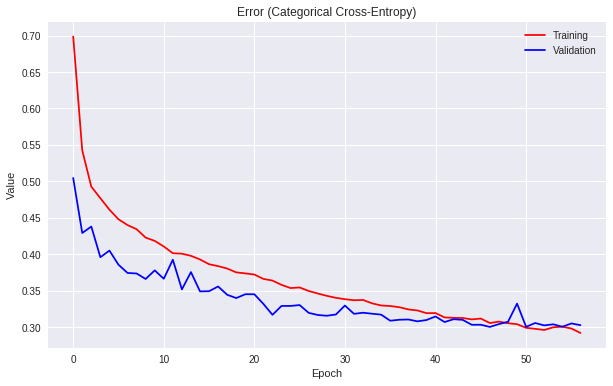

In [47]:
f, ax = plt.subplots()
f.set_size_inches(10, 6)
    
ax.plot(history.history["loss"], c="r")
ax.plot(history.history["val_loss"], c="b")
ax.set_title("Error (Categorical Cross-Entropy)")
ax.set_ylabel("Value")
ax.set_xlabel("Epoch")
ax.legend(["Training", "Validation"], loc="best");